In [1]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 12.3 MB/s eta 0:00:00


In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Dropout, UpSampling2D, Concatenate
from keras.saving import register_keras_serializable
from PIL import Image
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Register custom layers with Keras
@register_keras_serializable(package="Custom", name="table_decoder")
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result

@register_keras_serializable(package="Custom", name="column_decoder")
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', name='column_mask')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.drop(result)
        result = self.conv2(result)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result

# Load the model using the custom objects
model_path = '/kaggle/input/my-table-model/mymodel_199.keras'  # Update with your model path
model = tf.keras.models.load_model(model_path, custom_objects={'table_decoder': table_decoder, 'column_decoder': column_decoder})

# Define paths for ICDAR dataset and output images
icdar_data_path = '/kaggle/input/table-detection/Images/Images'  # Update with actual path if different
output_images_path = '/kaggle/working/output_images'
os.makedirs(output_images_path, exist_ok=True)

# Set up PDF document with reportlab
pdf_output_path = '/kaggle/working/icdar_comparisons.pdf'
pdf = canvas.Canvas(pdf_output_path, pagesize=letter)

# Helper function to process model predictions into masks
def masks(mask1, mask2):
    # Apply any necessary post-processing on mask outputs
    return mask1, mask2  # Modify as needed based on your model's output format



/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'table_mask', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'column_mask', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [3]:
# Load and process images directly from the ICDAR dataset directory
image_files = os.listdir(icdar_data_path)
for i, image_file in enumerate(image_files[:10]):  # Limit to first 100 images
    image_path = os.path.join(icdar_data_path, image_file)
    
    # Convert BMP to JPEG and resize
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize((1024, 1024))  # Resize to model's expected input shape
        img = img_to_array(img) / 255.0  # Normalize if required
        img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Run predictions with the loaded model
    mask1, mask2 = model.predict(img)
    table_mask, column_mask = masks(mask1, mask2)  # Process masks

    # Titles and Images for visualization
    titles = ['Input Image', 'Predicted Table Mask', 'Predicted Column Mask']
    images = [img[0], table_mask[0], column_mask[0]]  # Unpack to visualize single sample

    plt.figure(figsize=(20, 10))
    for j, (title, img) in enumerate(zip(titles, images)):
        plt.subplot(1, 3, j + 1)
        plt.imshow(img, cmap='gray' if j > 0 else None)  # Display masks in grayscale
        plt.title(title, fontsize=15)
        plt.axis('off')

    # Save the figure as a temporary image
    fig_path = f"{output_images_path}/comparison_{i + 1}.png"
    plt.savefig(fig_path, bbox_inches='tight')
    plt.close()

I0000 00:00:1730266218.476838      69 service.cc:145] XLA service 0x7b213000c9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730266218.476886      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


I0000 00:00:1730266225.750878      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [4]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

# Define paths
image_files = os.listdir(icdar_data_path)
output_images_path = 'extracted_images'  # Folder to save outputs
os.makedirs(output_images_path, exist_ok=True)  # Create output directory if it doesn't exist

# Load and process images from the provided list of file paths
for i, image_file in enumerate(image_files[:10]):  # Limit to first 10 images
    image_path = os.path.join(icdar_data_path, image_file)  # Assuming full path is given in 'image_file'

    # Convert BMP to JPEG and resize
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        img = img.resize((1024, 1024))  # Resize to model's expected input shape
        img_array = img_to_array(img) / 255.0  # Normalize if required
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Run predictions with the loaded model
    mask1, mask2 = model.predict(img_array)
    table_mask, column_mask = masks(mask1, mask2)  # Process masks

    # Save input image, table mask, and column mask
    img.save(f"{output_images_path}/image_{i + 1}.bmp")
    Image.fromarray((table_mask[0] * 255).astype(np.uint8)).save(f"{output_images_path}/table_mask_{i + 1}.bmp")
    Image.fromarray((column_mask[0] * 255).astype(np.uint8)).save(f"{output_images_path}/column_mask_{i + 1}.bmp")

print(f"Images and masks saved to {output_images_path}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Images and masks saved to extracted_images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


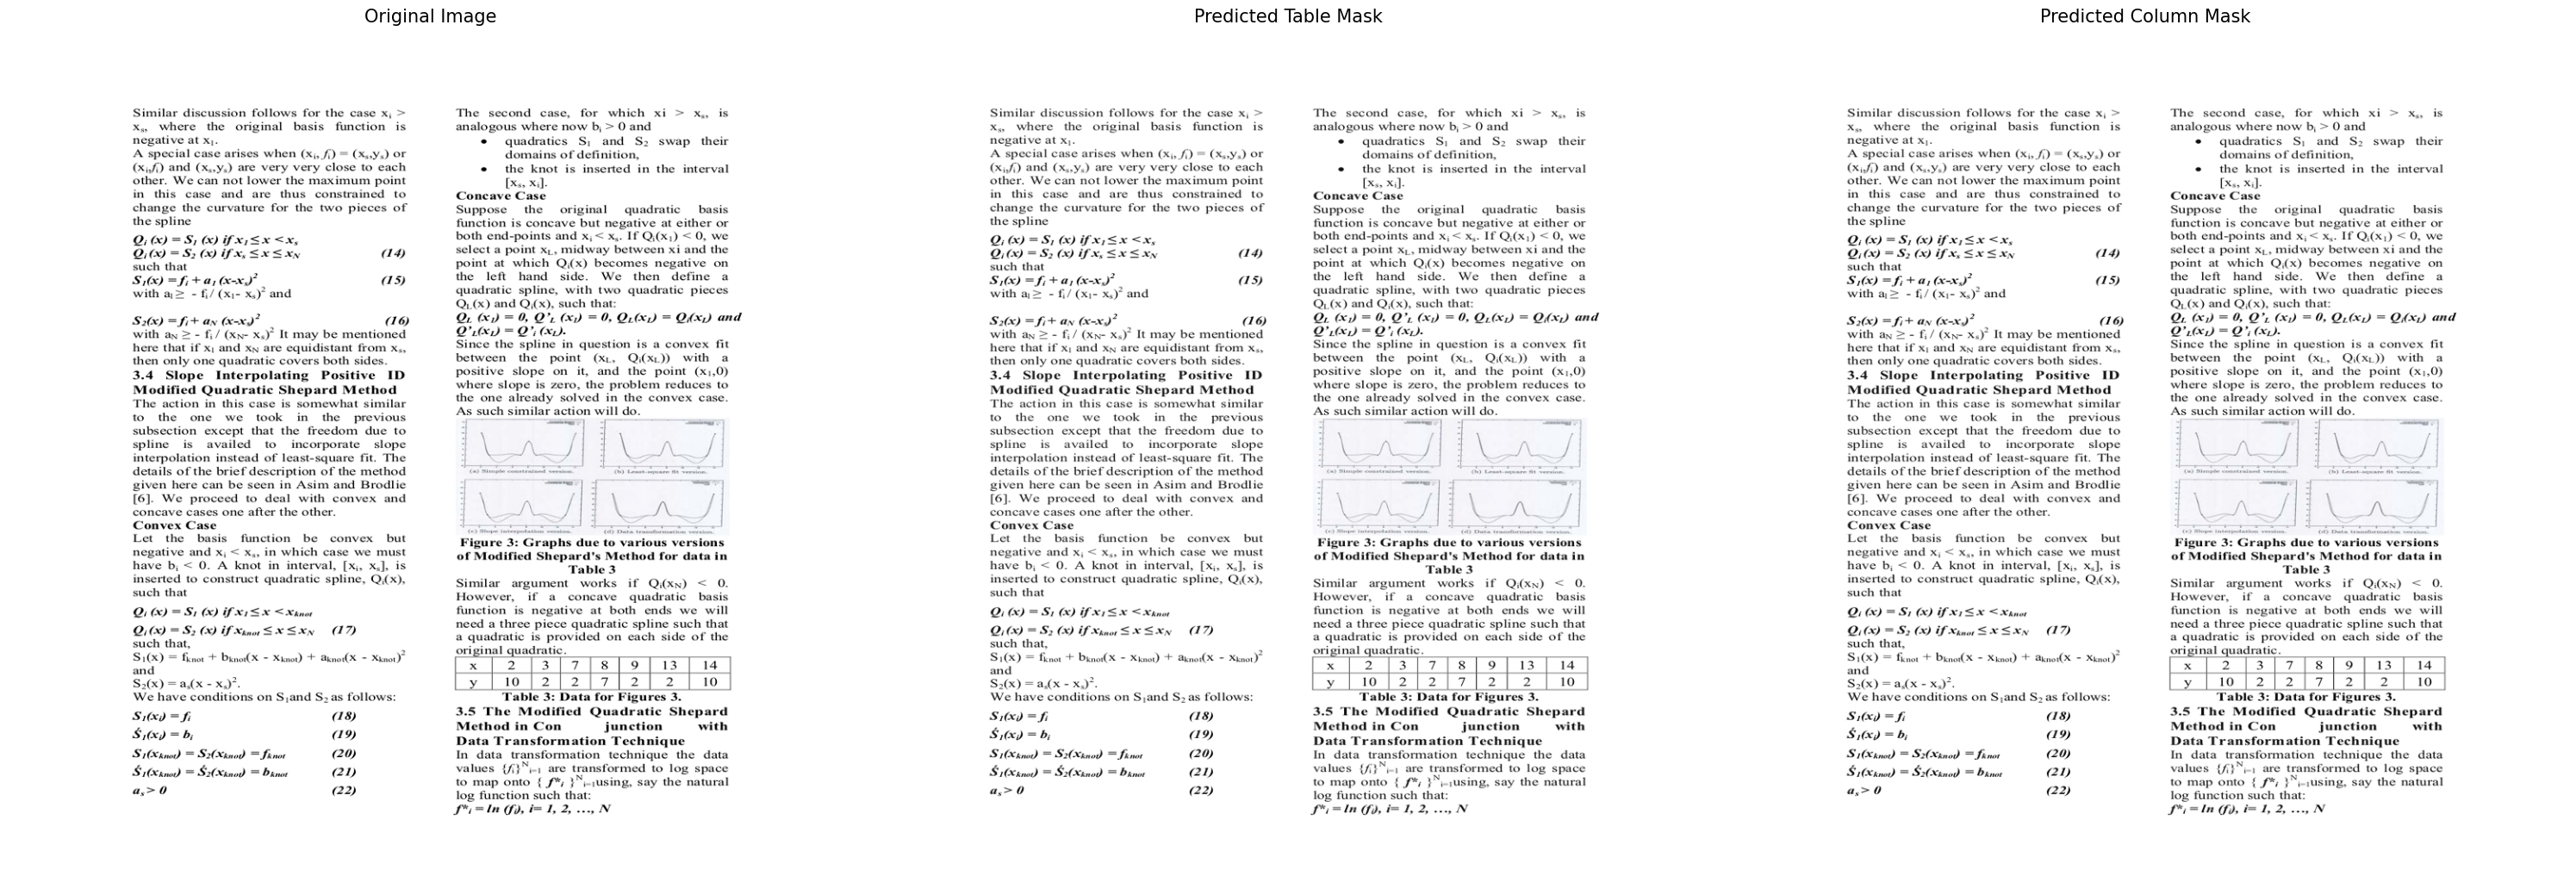

In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np

# Load and preprocess the image (similar to the reference code)
test_image = tf.io.read_file(f"{output_images_path}/image_2.bmp")
test_image = tf.image.decode_bmp(test_image, channels=3)
test_image = tf.image.convert_image_dtype(test_image, tf.float32)
test_image = tf.image.resize(test_image, [1024, 1024])

# Add a batch dimension
image_batch = tf.expand_dims(test_image, axis=0)

# Use the model to predict table and column masks
mask1, mask2 = model.predict(image_batch)

# Convert predicted masks to images
pred_table_mask = tf.keras.preprocessing.image.array_to_img(mask1[0])
pred_table_mask = pred_table_mask.convert('L')

pred_column_mask = tf.keras.preprocessing.image.array_to_img(mask2[0])
pred_column_mask = pred_column_mask.convert('L')

# Titles for visualization
titles = ['Original Image', 'Predicted Table Mask', 'Predicted Column Mask']

# Plotting
plt.figure(figsize=(30, 50))
for i, title in enumerate(titles):
    plt.subplot(1, 3, i + 1)
    if i == 0:
        plt.title(title, fontsize=15)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(test_image))
        plt.axis('off')
    elif i == 1:
        img_with_pred_table = tf.keras.preprocessing.image.array_to_img(test_image)
        img_with_pred_table.putalpha(pred_table_mask)
        plt.title(title, fontsize=15)
        plt.imshow(img_with_pred_table)
        plt.axis('off')
    else:
        img_with_pred_column = tf.keras.preprocessing.image.array_to_img(test_image)
        img_with_pred_column.putalpha(pred_column_mask)
        plt.title(title, fontsize=15)
        plt.imshow(img_with_pred_column)
        plt.axis('off')

plt.tight_layout()
plt.show()
